1. Reading combined extracted data

In [2414]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#import plotly.express as px

In [2415]:
pd.set_option('display.max_columns', None)   # show all columns

In [2416]:
df = pd.read_csv('combined_accidents.csv')
df.head()

,publish_date,content,time_24h,corrected_date,injury_severity,affected_party,car,motorbike,larger_vehicle,primary_accident_type_code,age,ages_after_driven_by,driver_age_min,driver_age_max,location,street,locality,day_of_week_num,rush_hour,rain_today,rain_last_3h,temp_avg,temp_min,temp_max,precip_mm_day,roadworks_nearby
0,2024-12-11,"A 60-year-old woman residing in Swieqi, at aro...",11:15,2024-12-11,grievous,pedestrian,1,0,0,PED,"['60', '48']",[48],48.0,48.0,"Swieqi, at around 1115hrs, was taken to Mater ...","Swieqi, at around 1115hrs",was taken to Mater Dei Hospital because she wa...,2,0,False,False,14.1,8.9,19.6,0.0,False
1,2024-12-11,"Update:Unfortunately, the 54-year-old Englishm...",17:00,2024-12-11,death,motorcyclist,0,1,0,FXOBJ,"['54', '54']",[],54.0,54.0,Mater Dei Hospital,Mater Dei Hospital,NaN,2,1,False,False,14.1,8.9,19.6,0.0,False
2,2024-12-14,"A 17-year-old girl, residing in Qormi, yesterd...",17:30,2024-12-13,serious,pedestrian,1,0,0,PED,"['17', '52']",[52],52.0,52.0,"Qormi, yesterday, at around 1730hrs, was taken...","Qormi, yesterday, at around 1730hrs, was taken...",Mellieha,6,0,NaN,False,18.8,16.9,21.0,NaN,False
3,2024-12-14,"Yesterday, at around (1945hrs), the police wer...",19:45,2024-12-13,minor,driver,1,0,0,COLL,"['50', '29']",[50],50.0,50.0,"Dawret il-Gudja, Gudja",Dawret il-Gudja,Gudja,6,0,NaN,False,18.8,16.9,21.0,NaN,True
4,2024-12-14,"Yesterday, at around (1945hrs), the police wer...",19:45,2024-12-13,serious,driver,1,0,0,COLL,"['50', '29']",[50],50.0,50.0,"Dawret il-Gudja, Gudja",Dawret il-Gudja,Gudja,6,0,NaN,False,18.8,16.9,21.0,NaN,True


Part 1: Injury Severity and Affected Party

In [2417]:
#injuiry severity value counts
df['injury_severity'].value_counts()


#note: no injuries can be grouped together with minor injuries for analysis purposes. Critical and grievous injuries can be also grouped. 
#the grievous castegory is the largest and can be reduced to balance the dataset more.


injury_severity
minor          89
grievous       77
serious        40
death          23
no injuries     2
critical        1
Name: count, dtype: int64

In [2418]:
df['injury_severity'] = df['injury_severity'].replace({'no injuries':'minor', 'critical':'death'})
df['injury_severity'].value_counts()

injury_severity
minor       91
grievous    77
serious     40
death       24
Name: count, dtype: int64

<Axes: ylabel='count'>

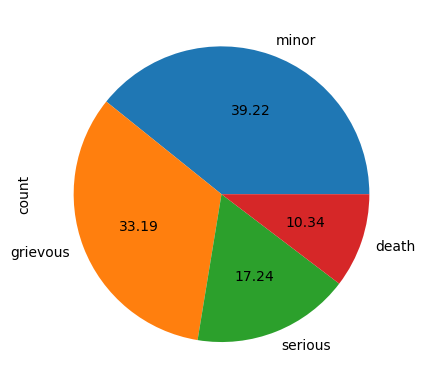

In [2419]:
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')

In [2420]:
#injuiry severity value counts
df['affected_party'].value_counts()

#note: cyclist and pedestrian can be grouped together

affected_party
driver          113
motorcyclist     75
pedestrian       40
cyclist           4
Name: count, dtype: int64

In [2421]:
#df['affected_party'] = df['affected_party'].replace({'cyclist':'pedestrian'})
#df['affected_party'].value_counts()

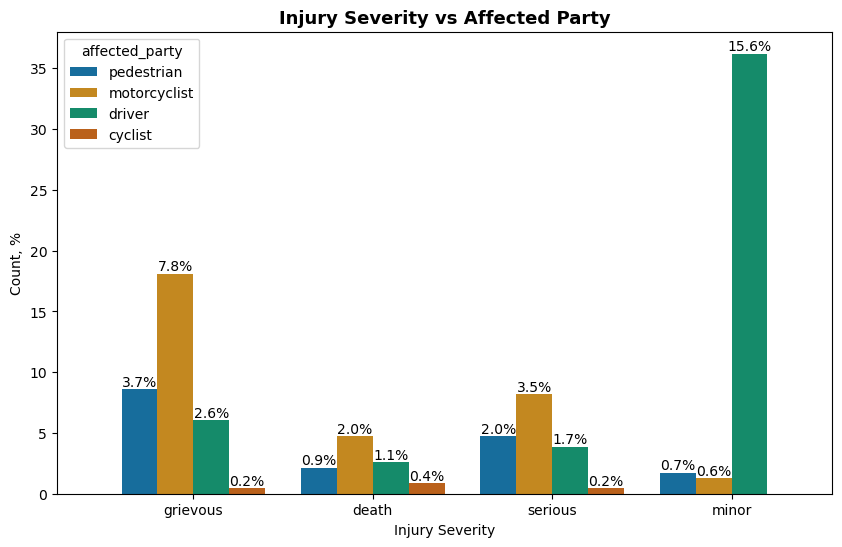

<Figure size 1000x600 with 0 Axes>

In [2422]:
#1. Injury severity vs affected party
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="injury_severity", hue = 'affected_party', stat="percent", palette = 'colorblind', data=df)

total = df['injury_severity'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Count, %')

ax.set_title('Injury Severity vs Affected Party', fontsize=13, fontweight='bold')
plt.figure(figsize=(10, 6))
plt.show()

#motorcyclists are fatalists

Part 2. Vehicles type involved

In [2423]:
#accident severity vs vehicles involved
#encoding vehicle types in the following way: motorcycle - 1 , car - 2, larger vehicles - 3. A sum of the vehicle types is stored in a new column 'vehicle_type_score'"AI journal"
# if the sum is 1, it means only a motorcycle was involved, 2 - only a car, 3 - a car and a motorcycle or only a larger vehicle, 4 - a larger vehicle and a motorcycle, 5 - all three types

df['primary_accident_type_code'] = df['primary_accident_type_code'].replace({'LOC':'OTH','ROLL':'OTH','OTHER':'OTH'})

idx_moto = df.loc[(df['affected_party']  == 'motorcyclist') & (df['motorbike'] == 0)].index
df.loc[idx_moto, 'motorbike'] = 1

df['car'] = df['car'].replace({1:2, 0:0})
df['larger_vehicle'] = df['larger_vehicle'].replace({1:4, 0:0})
df['vehicle_type_score'] = df['car'] + df['motorbike'] + df['larger_vehicle'] 
df['primary_accident_type_code'].value_counts()
df['vehicle_type_score'].value_counts()

vehicle_type_score
3    109
2     69
6     20
1     18
7     11
5      3
0      2
Name: count, dtype: int64

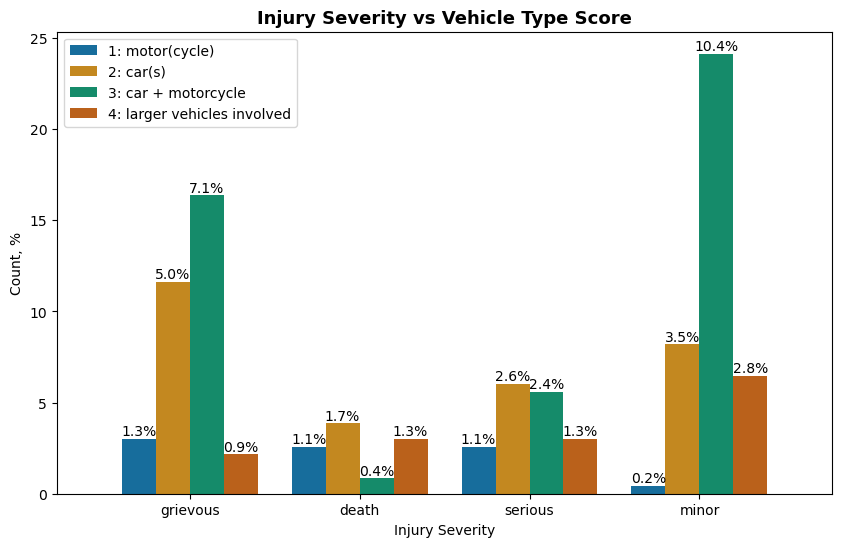

<Figure size 1000x600 with 0 Axes>

In [2424]:
#vehicle type score

df['vehicle_type_score'] = df['vehicle_type_score'].replace({0:1,1:1,3:3,4:4,5:4,6:4,7:4})
df['vehicle_type_score'].value_counts()


#injury severity vs vehicle type score
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="injury_severity", hue = 'vehicle_type_score', stat="percent", palette = 'colorblind', data=df)

total = df['injury_severity'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Count, %')
ax.set_title('Injury Severity vs Vehicle Type Score', fontsize=13, fontweight='bold')
ax.legend(labels = ['1: motor(cycle)', '2: car(s)', '3: car + motorcycle', '4: larger vehicles involved'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()

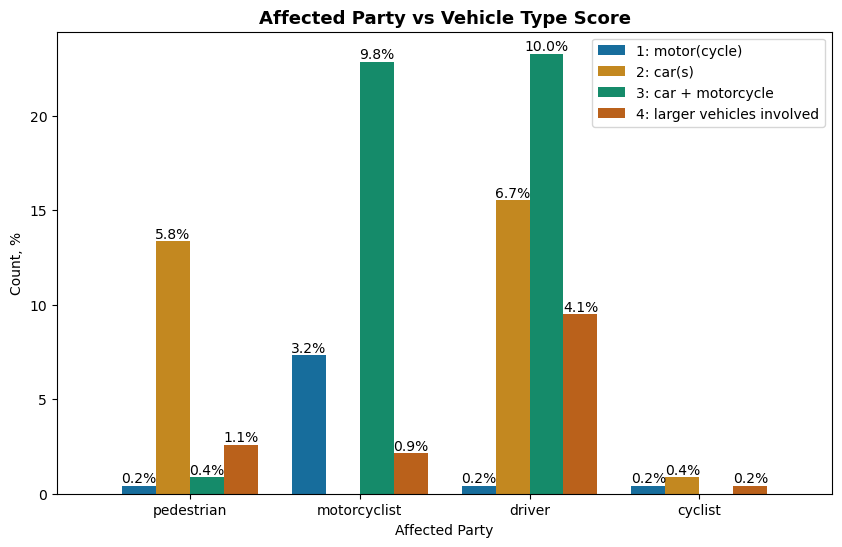

<Figure size 1000x600 with 0 Axes>

In [2425]:
#affected party vs vehicle type score
plt.figure(figsize=(10, 6))
ax=sns.countplot(x='affected_party', hue = 'vehicle_type_score', stat="percent", palette = 'colorblind', data=df)

total = df['affected_party'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Affected Party', ylabel='Count, %')
ax.set_title('Affected Party vs Vehicle Type Score', fontsize=13, fontweight='bold')
ax.legend(labels = ['1: motor(cycle)', '2: car(s)', '3: car + motorcycle', '4: larger vehicles involved'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()


Part 3. Primary accident type analysis

In [2426]:
df['primary_accident_type_code'] = df['primary_accident_type_code'].replace({'LOC':'OTH','ROLL':'OTH','OTHER':'OTH'})
df['primary_accident_type_code'].value_counts()

primary_accident_type_code
COLL     154
PED       39
FXOBJ     24
OTH       15
Name: count, dtype: int64

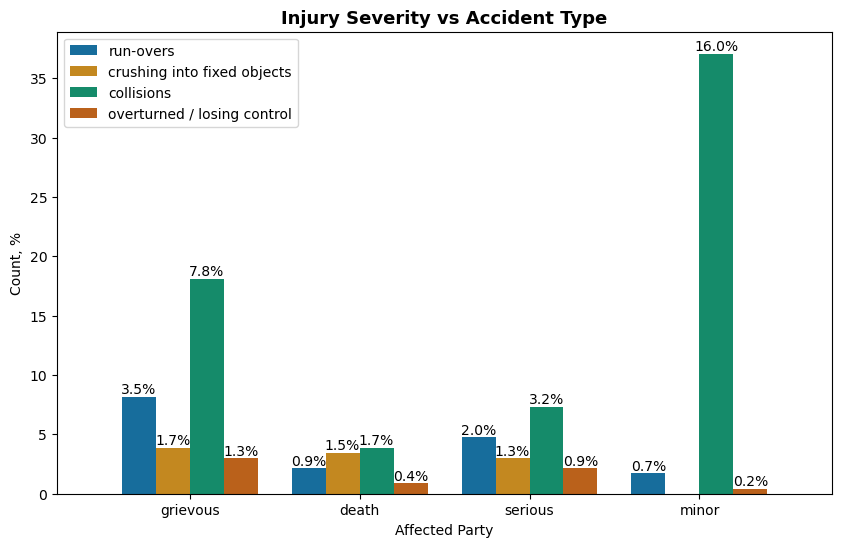

<Figure size 1000x600 with 0 Axes>

In [2427]:
# 2. Injury severity vs primary accident type code
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="injury_severity", hue = 'primary_accident_type_code', stat="percent", palette = 'colorblind', data=df)

total = df['injury_severity'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Affected Party', ylabel='Count, %')
ax.set_title('Injury Severity vs Accident Type', fontsize=13, fontweight='bold')
ax.legend(labels = ['run-overs', 'crushing into fixed objects', 'collisions', 'overturned / losing control'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()

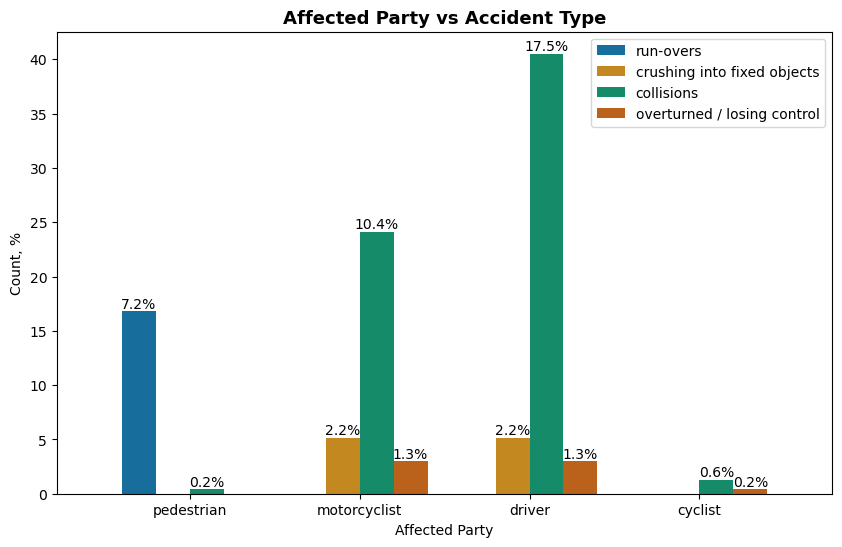

<Figure size 1000x600 with 0 Axes>

In [2428]:
#3. Affected party vs primary accident type code
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="affected_party", hue = 'primary_accident_type_code', stat="percent", palette = 'colorblind', data=df)

total = df['affected_party'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Affected Party', ylabel='Count, %')
ax.set_title('Affected Party vs Accident Type', fontsize=13, fontweight='bold')
ax.legend(labels = ['run-overs', 'crushing into fixed objects', 'collisions', 'overturned / losing control'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()

#this shows that leading types of accidents for motorcyclysts are collision, followed by crushing into obstacles;
#for drivers, collisions and crushing into obstacles are equally frequent;
#the pedestrian category should have only one accident type - running over pedestrians, but since we joined it with the cyclist category, it shows collisions as well.

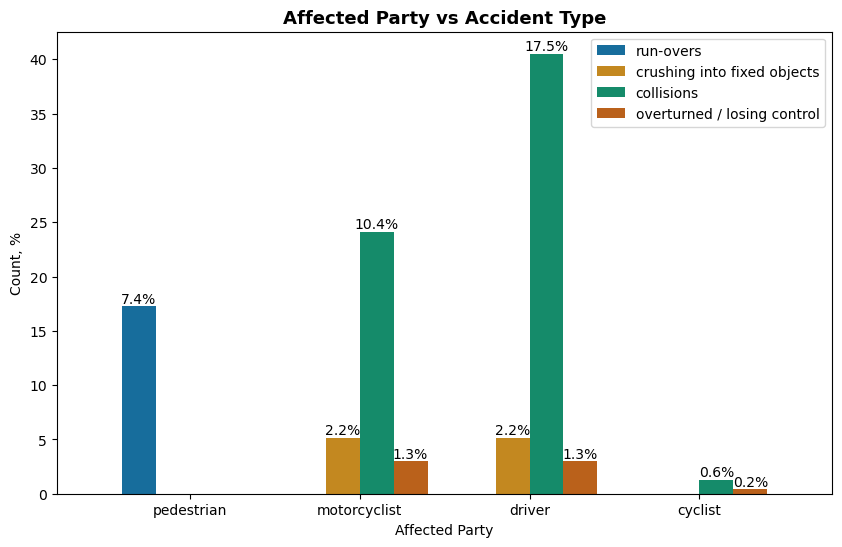

<Figure size 1000x600 with 0 Axes>

In [2429]:
#correcting the accident type for pedestrians: all pedestrians are involved only in PED accidents
idx_ped = df.loc[(df['affected_party']  == 'pedestrian') & (df['primary_accident_type_code'] != 'PED')].index
df.loc[idx_ped, 'primary_accident_type_code'] = 'PED'

#3. Affected party vs primary accident type code
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="affected_party", hue = 'primary_accident_type_code', stat="percent", palette = 'colorblind', data=df)

total = df['affected_party'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Affected Party', ylabel='Count, %')
ax.set_title('Affected Party vs Accident Type', fontsize=13, fontweight='bold')
ax.legend(labels = ['run-overs', 'crushing into fixed objects', 'collisions', 'overturned / losing control'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()


Part 4. Driver age analysis

In [2430]:
#introducing an addition driver age parameter:
#if an accident includes a driver under 28yo or over 65yo, the count is 1, otherwise it is 0

df['risky_age'] = ((df['driver_age_min'] <= 28) | 
                   (df['driver_age_max'] >= 65)).astype(int)
df['risky_age']

0      0
1      0
2      0
3      0
4      0
      ..
227    1
228    1
229    1
230    1
231    1
Name: risky_age, Length: 232, dtype: int32

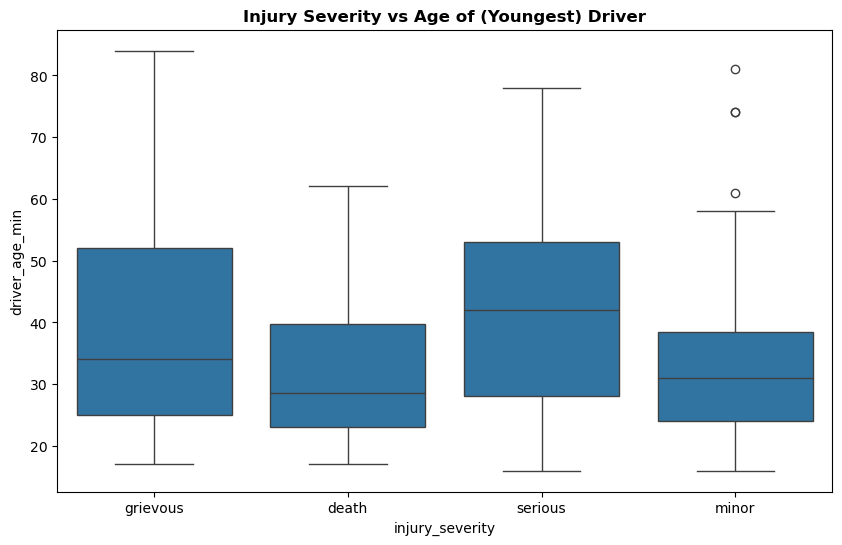

In [2431]:
#driver age analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='injury_severity', y='driver_age_min')
ax.set_title('Injury Severity vs Age of (Youngest) Driver', fontsize=12, fontweight='bold')
plt.show()

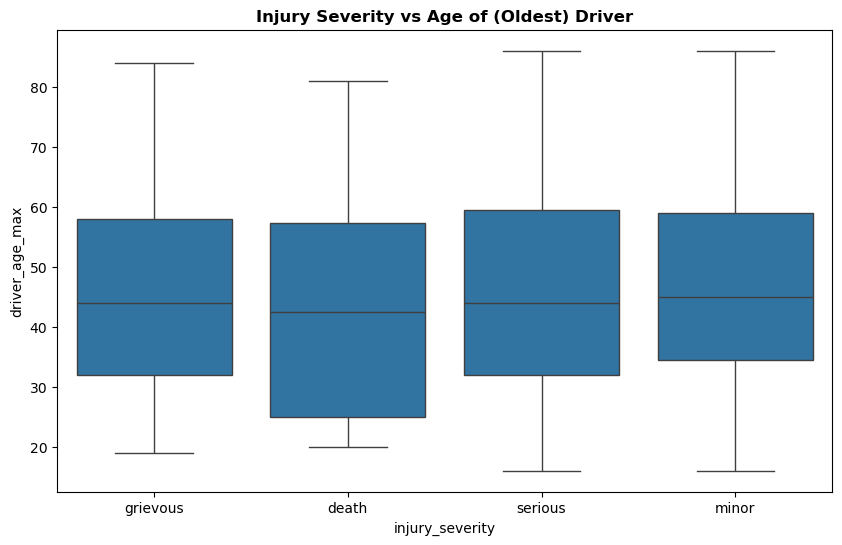

In [2432]:
#driver age analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='injury_severity', y='driver_age_max')
ax.set_title('Injury Severity vs Age of (Oldest) Driver', fontsize=12, fontweight='bold')
plt.show()

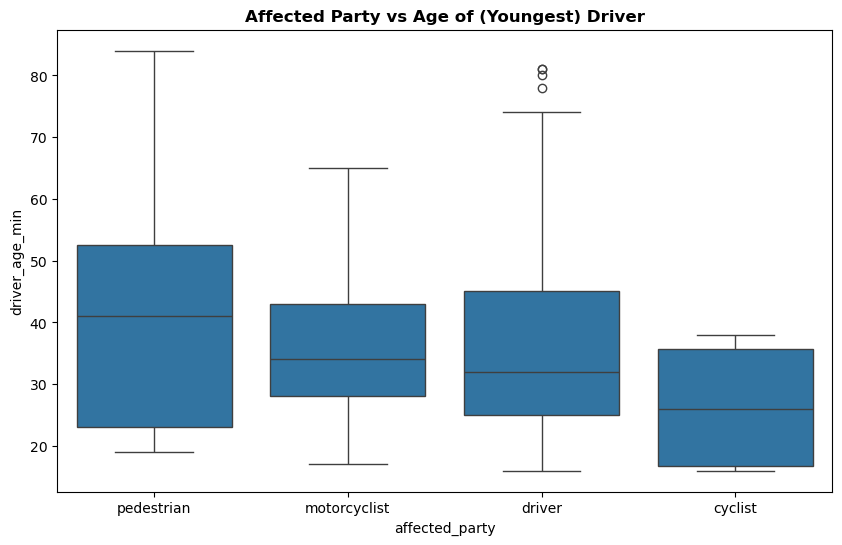

In [2433]:
#driver age analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='affected_party', y='driver_age_min')
ax.set_title('Affected Party vs Age of (Youngest) Driver', fontsize=12, fontweight='bold')
plt.show()

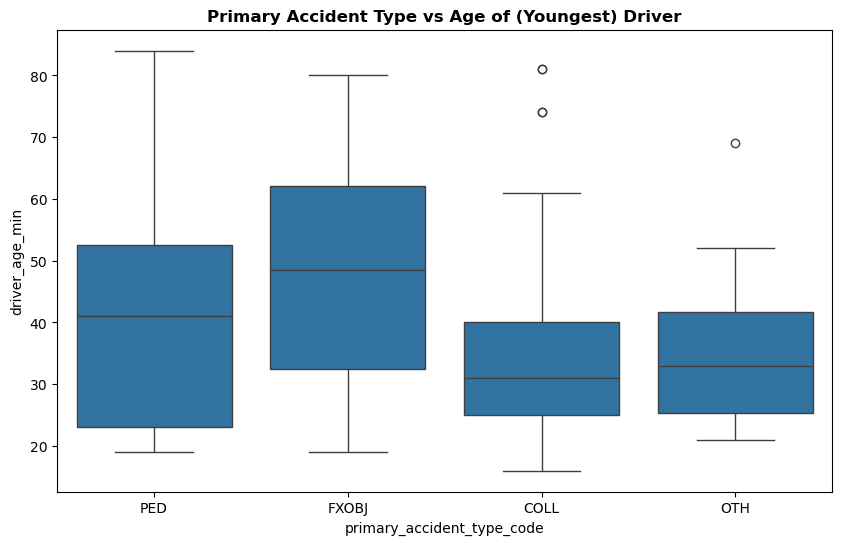

In [2434]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='primary_accident_type_code', y='driver_age_min')
ax.set_title('Primary Accident Type vs Age of (Youngest) Driver', fontsize=12, fontweight='bold')
plt.show()

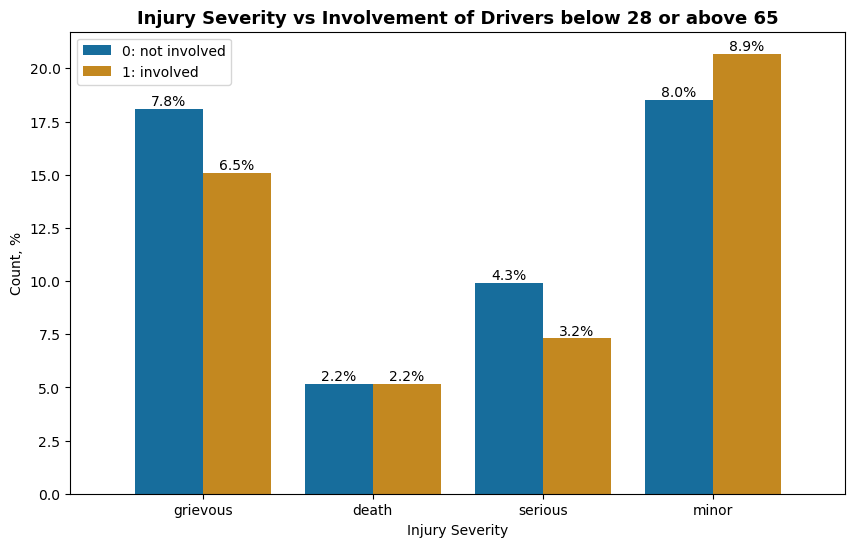

<Figure size 1000x600 with 0 Axes>

In [2435]:
#risky age parameter
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="injury_severity", hue = 'risky_age', stat="percent", palette = 'colorblind', data=df)

total = df['injury_severity'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Count, %')
ax.set_title('Injury Severity vs Involvement of Drivers below 28 or above 65', fontsize=13, fontweight='bold')
ax.legend(labels = ['0: not involved', '1: involved'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()

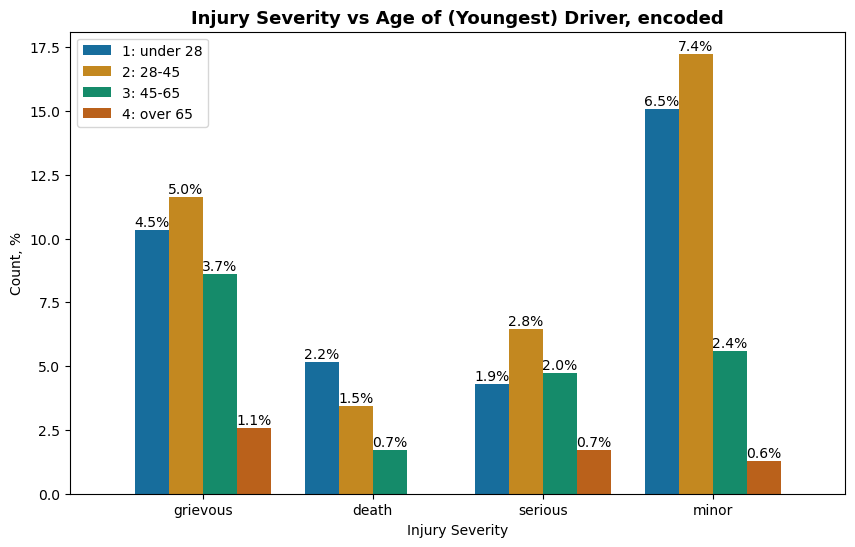

<Figure size 1000x600 with 0 Axes>

In [2436]:
#minimum driver age encoded

df['driver_age_min'] = pd.to_numeric(df['driver_age_min'], errors='coerce')
df['driver_age_min'] = df['driver_age_min'].fillna(df['driver_age_min'].median())

# Define bins and labels (these bins were detected by trying out different age groups and seeing how the graph responds)
bins = [-float('inf'), 28, 45, 65, float('inf')]
labels = ['1', '2', '3', '4']

# Use pd.cut with right=True (<= upper bound), include_lowest=True
bands = pd.cut(df['driver_age_min'], bins=bins, labels=labels, right=True, include_lowest=True)

df['age_min_encoded'] = bands

#driver age analysis
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="injury_severity", hue = 'age_min_encoded', stat="percent", palette = 'colorblind', data=df)

total = df['injury_severity'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Count, %')
ax.set_title('Injury Severity vs Age of (Youngest) Driver, encoded', fontsize=13, fontweight='bold')
ax.legend(labels = ['1: under 28', '2: 28-45', '3: 45-65', '4: over 65'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()



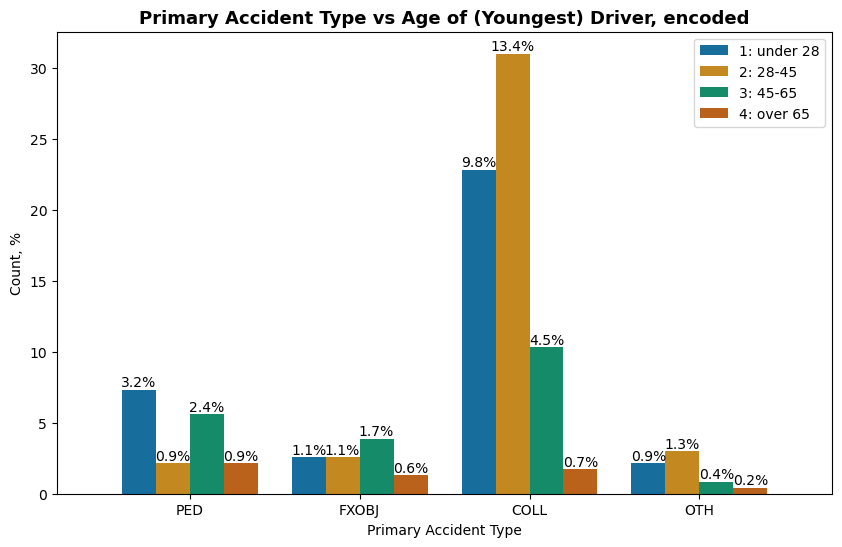

In [2437]:
#driver age analysis
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="primary_accident_type_code", hue = 'age_min_encoded', stat="percent", palette = 'colorblind', data=df)

total = df['primary_accident_type_code'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Primary Accident Type', ylabel='Count, %')
ax.set_title('Primary Accident Type vs Age of (Youngest) Driver, encoded', fontsize=13, fontweight='bold')
ax.legend(labels = ['1: under 28', '2: 28-45', '3: 45-65', '4: over 65'], loc='best')
plt.show()


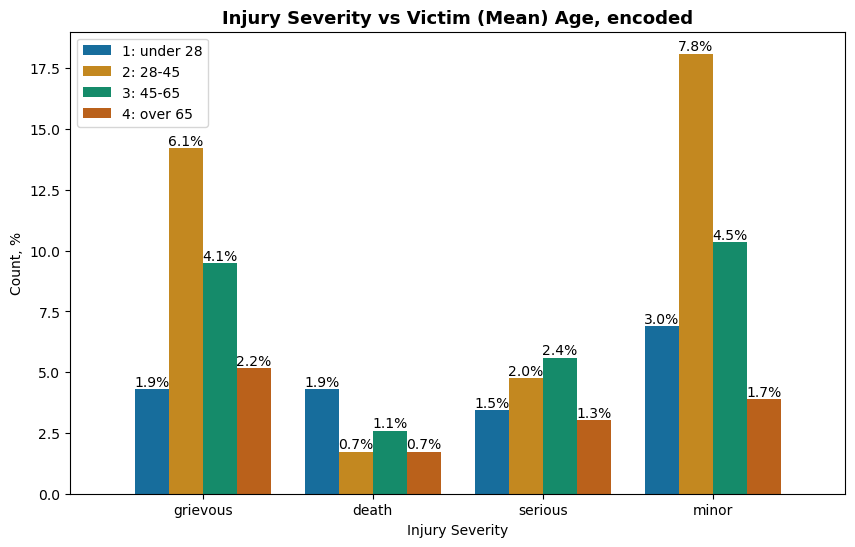

<Figure size 1000x600 with 0 Axes>

In [2438]:
#victim ages
import ast  # to safely parse list-like strings
 #Convert "['60','48']" into Python lists
df["age_list"] = df["age"].apply(lambda x: ast.literal_eval(x))

def extract_victim_age(row):
    min_age = row["driver_age_min"]
    max_age = row["driver_age_max"]

    # Loop through the age list in order
    for a in row["age_list"]:
        try:
            age_val = float(a)
        except:
            continue
        
        # If this age is NOT equal to min or max, return it
        if age_val not in (min_age, max_age):
            return age_val
    
    # If all ages = min or max → fallback to driver_age_min
    mean_age = (min_age+max_age)/2
    return mean_age

df['victim_age'] = df.apply(extract_victim_age, axis=1)

# Define bins and labels (these bins were detected by trying out different age groups and seeing how the graph responds)
bins = [-float('inf'), 28, 45, 65, float('inf')]
labels = ['1', '2', '3', '4']

# Use pd.cut with right=True (<= upper bound), include_lowest=True
bands = pd.cut(df['victim_age'], bins=bins, labels=labels, right=True, include_lowest=True)

df['victim_age_encoded'] = bands

#driver age analysis
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="injury_severity", hue = 'victim_age_encoded', stat="percent", palette = 'colorblind', data=df)

total = df['injury_severity'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Count, %')
ax.set_title('Injury Severity vs Victim (Mean) Age, encoded', fontsize=13, fontweight='bold')
ax.legend(labels = ['1: under 28', '2: 28-45', '3: 45-65', '4: over 65'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()





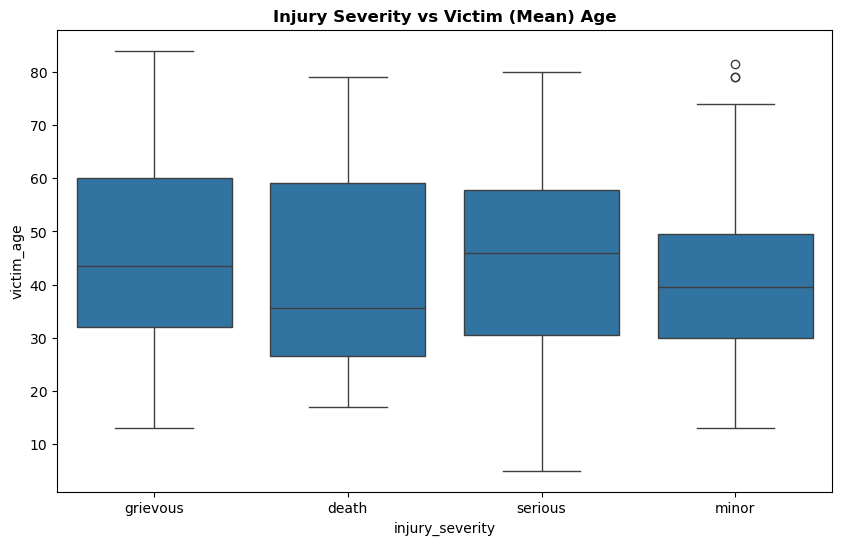

In [2439]:
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='injury_severity', y='victim_age')
ax.set_title('Injury Severity vs Victim (Mean) Age', fontsize=12, fontweight='bold')
plt.show()

Part 5. Time of the day analysis

In [2440]:
df['hour'] = pd.to_datetime(df['time_24h'], format='%H:%M', errors='coerce').dt.hour
display(df['hour'])

0      11
1      17
2      17
3      19
4      19
       ..
227     9
228     9
229     9
230     9
231     9
Name: hour, Length: 232, dtype: int32

In [2441]:
## The time-of-day categories were created using the cut method
df['time_period'] = pd.cut(
    df['hour'],
    bins=[0, 6, 12, 17, 24],
    labels=['Night', 'Morning', 'Afternoon', 'Evening'],
    right=False
)

In [2442]:
df.drop(columns=['hour'], inplace=True)
print(df[['time_24h', 'time_period']].head())

  time_24h time_period
0    11:15     Morning
1    17:00     Evening
2    17:30     Evening
3    19:45     Evening
4    19:45     Evening


In [2443]:
## Time Period Value Counts
df['time_period'].value_counts()

time_period
Morning      81
Evening      73
Afternoon    54
Night        24
Name: count, dtype: int64

C:\Users\galer173\AppData\Local\Temp\ipykernel_11476\4049694081.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['midnight-6am','6am-noon','noon-5pm','5pm-midnight'])


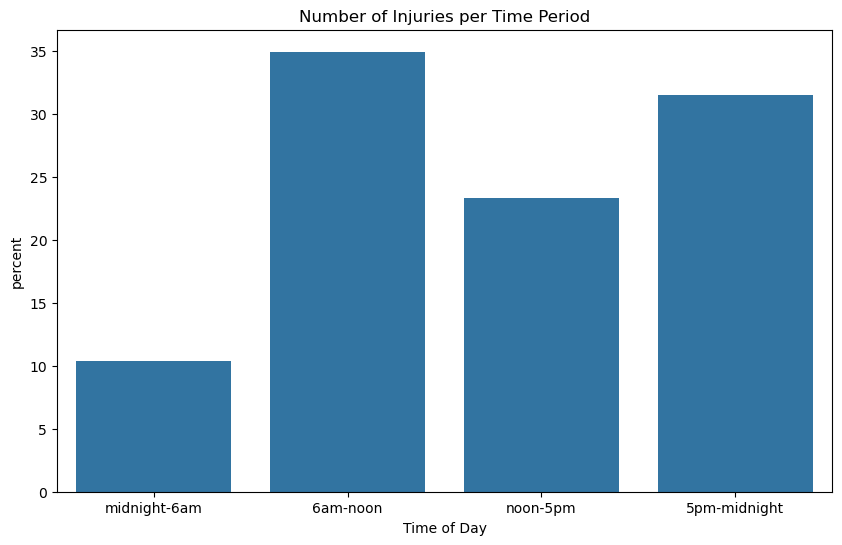

In [2444]:
## Time Period Analysis
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='time_period', stat="percent")
plt.xlabel('Time of Day')
plt.title('Number of Injuries per Time Period')
ax.set_xticklabels(['midnight-6am','6am-noon','noon-5pm','5pm-midnight'])
plt.show()

C:\Users\galer173\AppData\Local\Temp\ipykernel_11476\1791317797.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['midnight-6am','6am-noon','noon-5pm','5pm-midnight'])


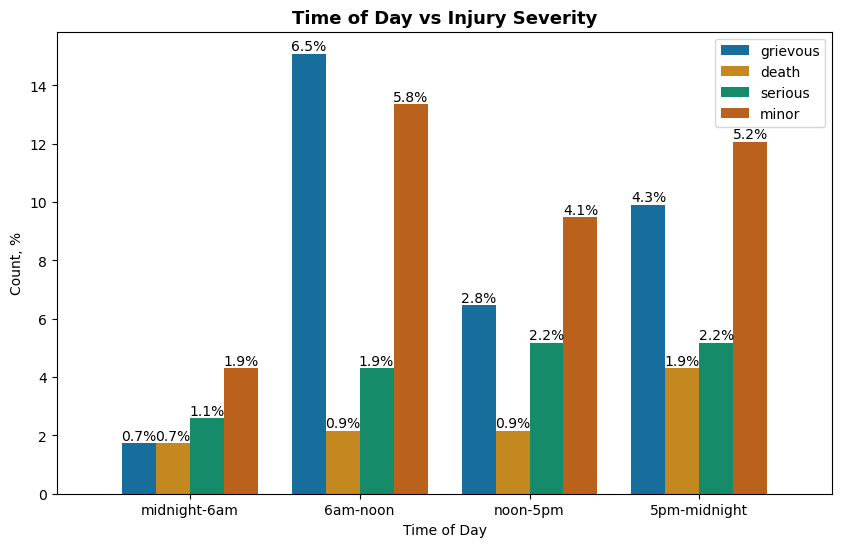

In [2445]:
#6. Injury Severity vs Time of Day

plt.figure(figsize=(10, 6))
ax=sns.countplot(x="time_period", hue = 'injury_severity', stat="percent", palette = 'colorblind', data=df)

total = df['injury_severity'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Time of Day', ylabel='Count, %')
ax.set_title('Time of Day vs Injury Severity', fontsize=13, fontweight='bold')
ax.set_xticklabels(['midnight-6am','6am-noon','noon-5pm','5pm-midnight'])
ax.legend(loc='best')
plt.show()



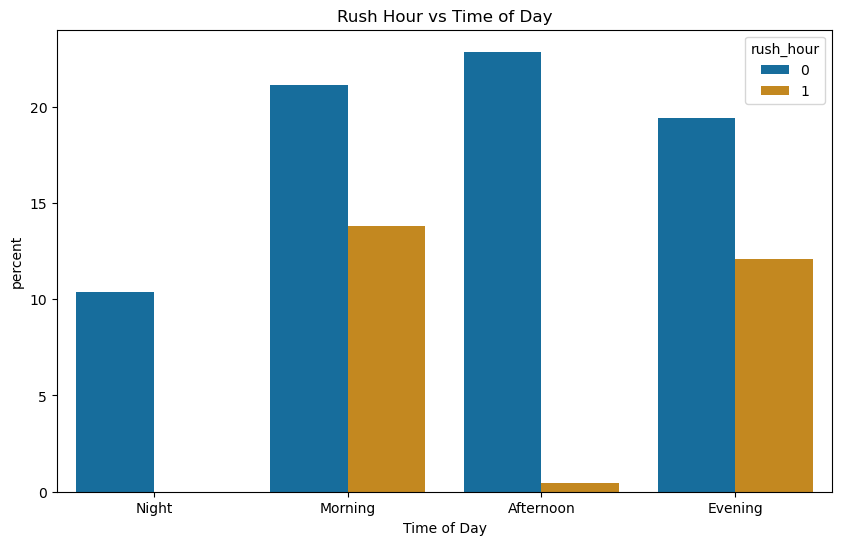

In [2446]:
##7. Rush Hour vs Time of Day
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='time_period', hue='rush_hour', stat="percent", palette = 'colorblind',)
plt.xlabel('Time of Day')
plt.title('Rush Hour vs Time of Day')
plt.show()

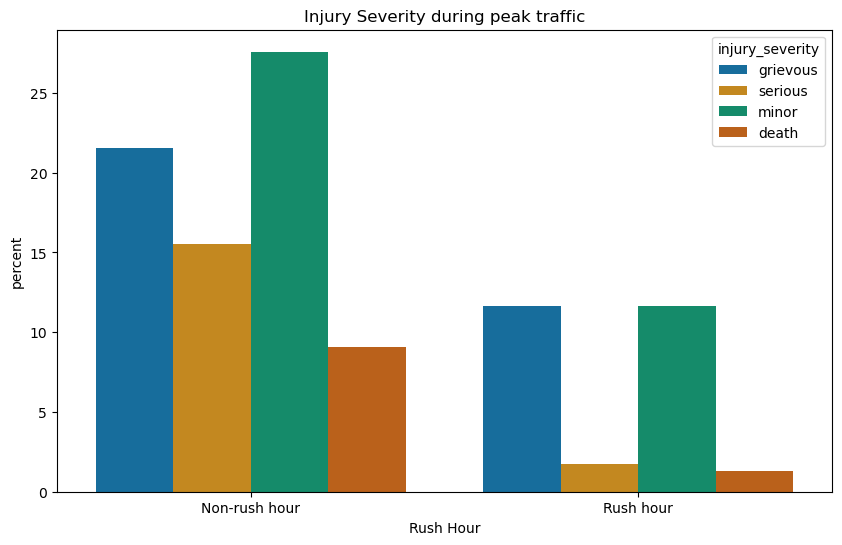

In [2447]:
## Evaluating Injury Severity During Peak Traffic
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='rush_hour', hue='injury_severity', stat="percent", palette = 'colorblind',)
plt.xticks([0, 1], ['Non-rush hour', 'Rush hour'])
plt.xlabel('Rush Hour')
plt.title('Injury Severity during peak traffic')
plt.show()

C:\Users\galer173\AppData\Local\Temp\ipykernel_11476\3032717375.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['midnight-6am','6am-noon','noon-5pm','5pm-midnight'])


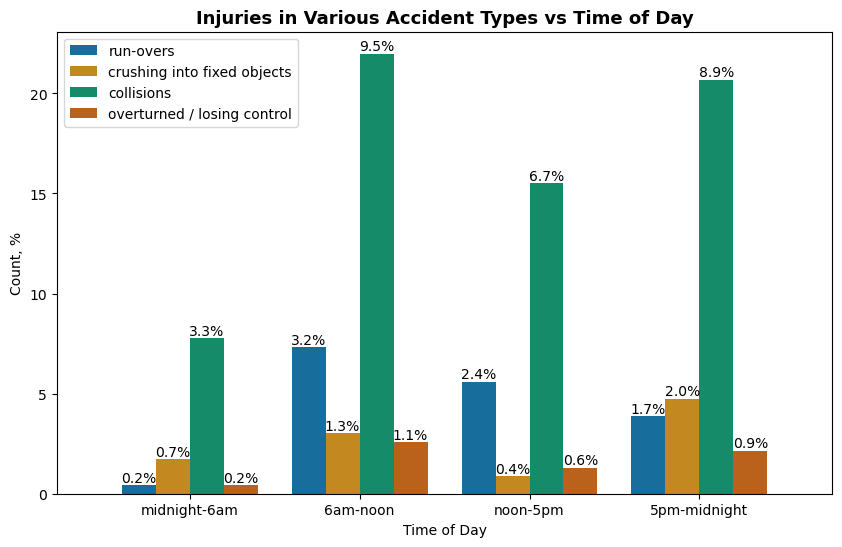

<Figure size 1000x600 with 0 Axes>

In [2448]:
##8. Accident Type vs Time of Day
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="time_period", hue = 'primary_accident_type_code', stat="percent", palette = 'colorblind', data=df)

total = df['primary_accident_type_code'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Time of Day', ylabel='Count, %')
ax.set_title('Injuries in Various Accident Types vs Time of Day', fontsize=13, fontweight='bold')
ax.legend(labels = ['run-overs', 'crushing into fixed objects', 'collisions', 'overturned / losing control'], loc='best')
ax.set_xticklabels(['midnight-6am','6am-noon','noon-5pm','5pm-midnight'])
plt.figure(figsize=(10, 6))
plt.show()


Part 6. Day of week analysis

C:\Users\galer173\AppData\Local\Temp\ipykernel_11476\3902987979.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])


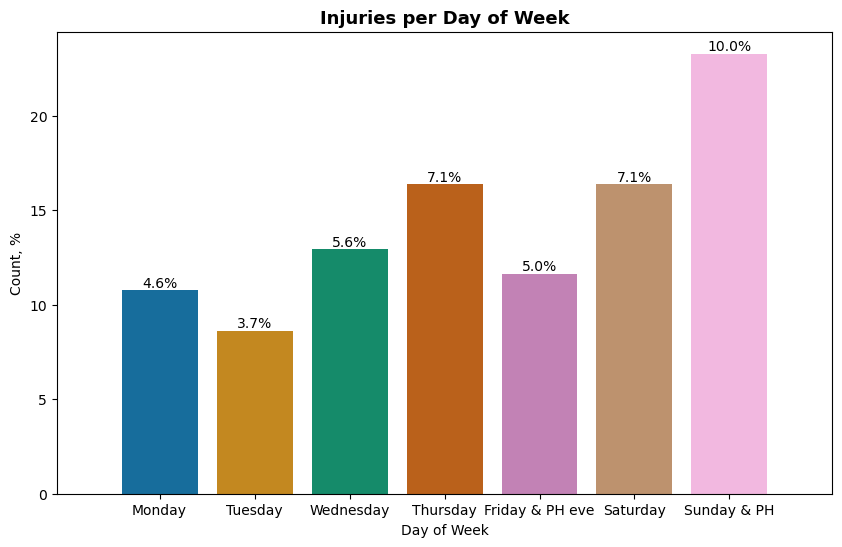

<Figure size 1000x600 with 0 Axes>

In [2449]:
#day of week analysis
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="day_of_week_num", hue = 'day_of_week_num', stat="percent", palette = 'colorblind', data=df)

total = df['day_of_week_num'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Day of Week', ylabel='Count, %')
ax.set_title('Injuries per Day of Week', fontsize=13, fontweight='bold')
ax.legend_.remove()
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])
#ax.legend(labels = ['run-overs', 'crushing into fixed objects', 'collisions', 'overturned / losing control'], loc='best')
plt.figure(figsize=(10, 6))
plt.show()


C:\Users\galer173\AppData\Local\Temp\ipykernel_11476\3315729414.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])


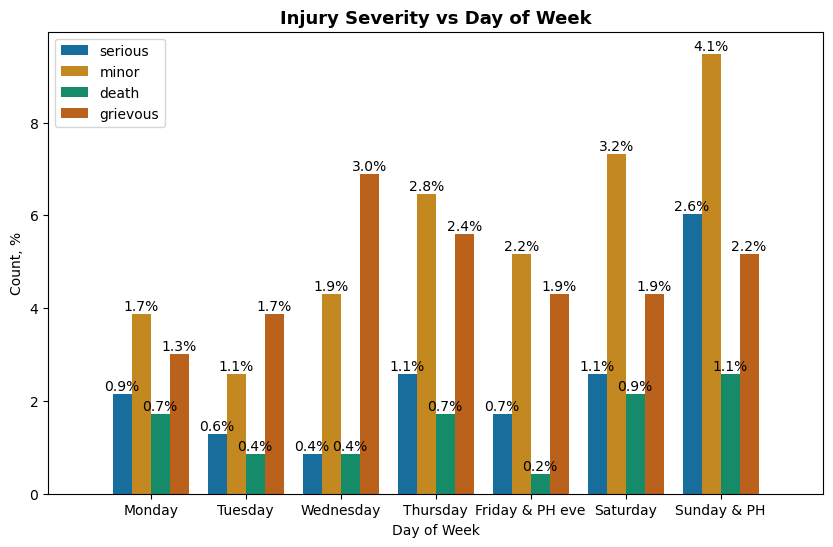

<Figure size 1000x600 with 0 Axes>

In [2450]:
#5. Injury severity vs day of the week

plt.figure(figsize=(10, 6))
ax=sns.countplot(x="day_of_week_num", hue = 'injury_severity', stat="percent", palette = 'colorblind', data=df)

total = df['day_of_week_num'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Day of Week', ylabel='Count, %')
ax.set_title('Injury Severity vs Day of Week', fontsize=13, fontweight='bold')
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])
ax.legend( loc='best')
plt.figure(figsize=(10, 6))
plt.show()


C:\Users\galer173\AppData\Local\Temp\ipykernel_11476\543105760.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])


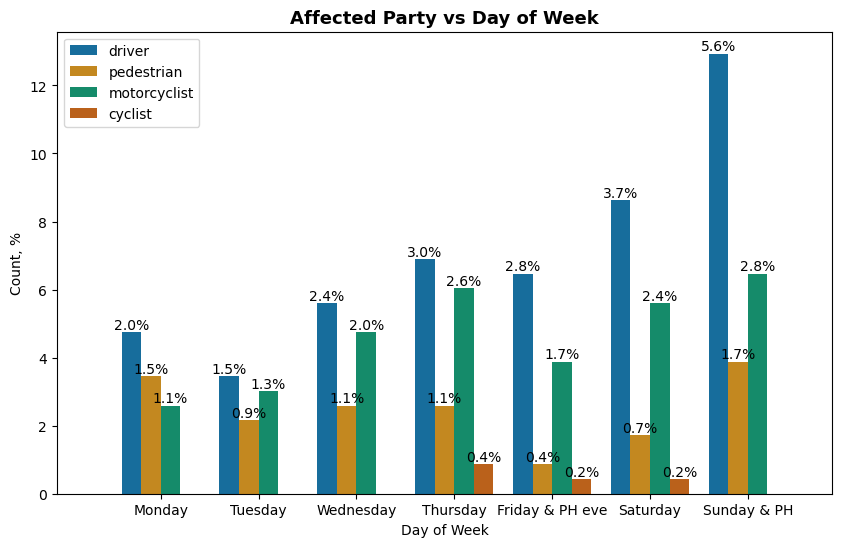

<Figure size 1000x600 with 0 Axes>

In [2451]:
#6. Affected party vs day of the week

plt.figure(figsize=(10, 6))
ax=sns.countplot(x='day_of_week_num', hue = 'affected_party', stat="percent", palette = 'colorblind', data=df)

total = df['day_of_week_num'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Day of Week', ylabel='Count, %')
ax.set_title('Affected Party vs Day of Week', fontsize=13, fontweight='bold')
ax.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday & PH eve','Saturday','Sunday & PH'])
ax.legend(loc='best')
plt.figure(figsize=(10, 6))
plt.show()


Part 7. Rain Analysis

In [2452]:
#filling nans in rain with booleans

df['rain_today'] = df['rain_today'].fillna(0).astype('bool')
df['rain_last_3h'] = df['rain_last_3h'].fillna(0).astype('bool')

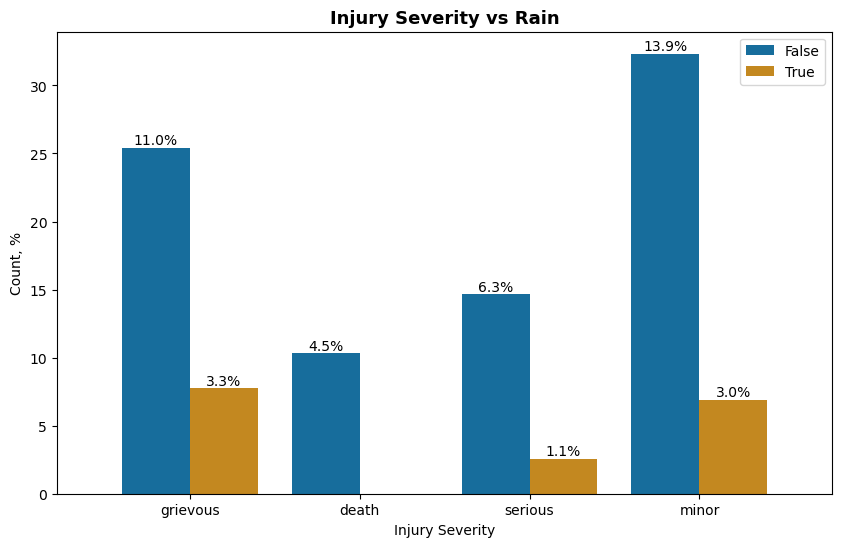

<Figure size 1000x600 with 0 Axes>

In [2453]:
plt.figure(figsize=(10, 6))
ax=sns.countplot(x="injury_severity", hue = 'rain_today', stat="percent", palette = 'colorblind', data=df)

total = df['injury_severity'].count()

# annotate the bars with fmt from matplotlib v3.7.0
for c in ax.containers:
    ax.bar_label(c, fmt=lambda x: f'{(x/total)*100:0.1f}%')
    # add space at the end of the bar for the labels
ax.margins(x=0.1)

ax.set(xlabel='Injury Severity', ylabel='Count, %')
ax.set_title('Injury Severity vs Rain', fontsize=13, fontweight='bold')

ax.legend(loc='best')
plt.figure(figsize=(10, 6))
plt.show()

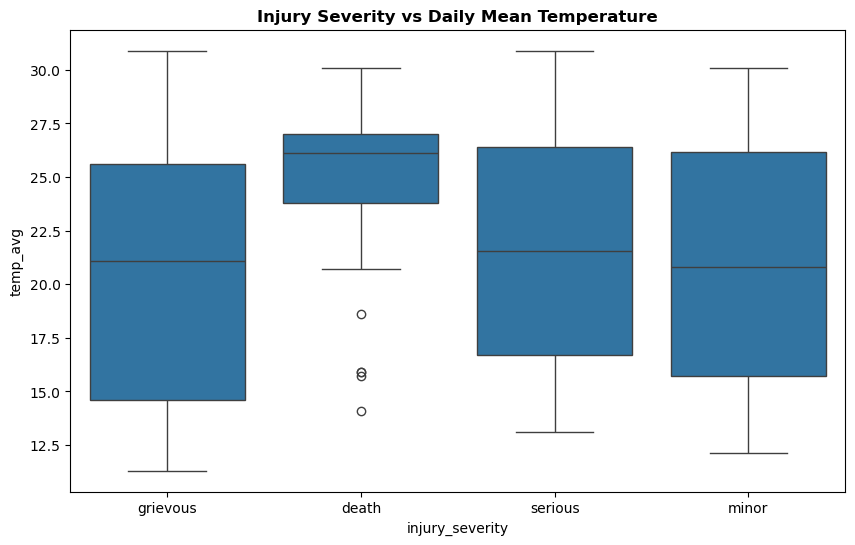

In [2454]:
#driver age analysis
plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='injury_severity', y='temp_avg')
ax.set_title('Injury Severity vs Daily Mean Temperature', fontsize=12, fontweight='bold')
plt.show()

In [2455]:
#the models will predict injury severity, based on the followig parameters:
#affected_party (classify grievous & minor accidents);
#primary_accident_type_code (grievous & minor accidents);
#rain_today (no fatalities on rainy days);
#vehicle_type_score (good parameter to classify grievous and minor injuries);
#age_min_encoded (most grievous injuries involve drivers under 28, no fatal accidents involve drivers over 65 );
#time_period (morning - the majority of grievous injuries)

Part 7. Locality analysis

In [2456]:
df['locality'].value_counts()

locality
Gozo                                                            12
Naxxar                                                          11
Marsa                                                           10
Żejtun                                                           6
Gudja                                                            6
                                                                ..
lost his life late last night in a traffic accident in Msida     1
Zabbar after a vehicle hit a number of people                    1
Balzan                                                           1
causing one of them to overturn                                  1
Birzebbugia                                                      1
Name: count, Length: 64, dtype: int64

In [2457]:
#outputting the updated combined file
#writing the output to a csv file
#dropping intermediate columns
df.drop(['car', 'motorbike', 'larger_vehicle', 'driver_age_max','temp_avg', 'temp_min','temp_max','precip_mm_day','risky_age','victim_age','victim_age_encoded'], axis=1, inplace=True)
output_file = "combined_accidents_clean.csv"
df.to_csv(output_file, index=False)

In [2458]:
#idx_GriMotoColl.size
#there are a lot of records of grievously injuired motorcyclists who crushed into fixed objects
#how to handle unbalanced data:
# https://www.geeksforgeeks.org/machine-learning/handling-imbalanced-data-for-classification/
#we can divide grievous and serious class in two groups and use the two minority classes with each of those two groups
#https://www.youtube.com/watch?v=ok2s1vV9XW0